<a href="https://colab.research.google.com/github/lebe1/ClimateChangeAI/blob/main/Multi-time-model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import random
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error

from skforecast.ForecasterAutoregMultiSeries import ForecasterAutoregMultiSeries

# Step 1 - Modeling

In [2]:
# Import data
df = pd.read_csv('df_list/df_42.csv', index_col=0, sep=';')

In [3]:
df.head()

,YYYY,MM,DD,DOY,2m_temp_max,2m_temp_mean,2m_temp_min,2m_dp_temp_max,2m_dp_temp_mean,2m_dp_temp_min,...,surf_net_therm_rad_max,surf_net_therm_rad_mean,surf_press,total_et,prec,volsw_123,volsw_4,elev,lon,lat
0,1981,1,1,1,0.1,-3.4,-7.9,-1.7,-6.0,-11.8,...,55,18,93487,-0.11,7.28,0.34,0.4,409,4296744,2695478
1,1981,1,2,2,-0.3,-2.0,-3.5,-2.0,-3.8,-5.0,...,25,13,93422,0.00,15.78,0.34,0.4,409,4296744,2695478
2,1981,1,3,3,4.1,2.0,-0.1,1.7,-1.0,-2.3,...,33,12,92340,0.06,14.44,0.34,0.4,409,4296744,2695478
3,1981,1,4,4,3.6,0.5,-2.3,1.7,-0.3,-3.6,...,76,19,91693,0.08,35.63,0.35,0.4,409,4296744,2695478
4,1981,1,5,5,-2.6,-3.5,-4.4,-4.5,-5.4,-6.6,...,72,31,92697,0.49,13.67,0.35,0.4,409,4296744,2695478


In [4]:
# Create new index based on date columns YYYY-MM
df['date'] = pd.to_datetime(dict(year=df['YYYY'], month=df['MM'], day=df['DD']))

# Set date as index
df.set_index('date', inplace=True)

df = df.asfreq('D')

# Drop columns
df.drop(['YYYY', 'MM', 'DD'], axis=1, inplace=True)

df.head()

,DOY,2m_temp_max,2m_temp_mean,2m_temp_min,2m_dp_temp_max,2m_dp_temp_mean,2m_dp_temp_min,10m_wind_u,10m_wind_v,fcst_alb,...,surf_net_therm_rad_max,surf_net_therm_rad_mean,surf_press,total_et,prec,volsw_123,volsw_4,elev,lon,lat
date,,,,,,,,,,,,,,,,,,,,,
1981-01-01,1,0.1,-3.4,-7.9,-1.7,-6.0,-11.8,1.4,0.9,0.49,...,55,18,93487,-0.11,7.28,0.34,0.4,409,4296744,2695478
1981-01-02,2,-0.3,-2.0,-3.5,-2.0,-3.8,-5.0,0.9,1.5,0.50,...,25,13,93422,0.00,15.78,0.34,0.4,409,4296744,2695478
1981-01-03,3,4.1,2.0,-0.1,1.7,-1.0,-2.3,1.4,1.8,0.50,...,33,12,92340,0.06,14.44,0.34,0.4,409,4296744,2695478
1981-01-04,4,3.6,0.5,-2.3,1.7,-0.3,-3.6,1.5,0.2,0.50,...,76,19,91693,0.08,35.63,0.35,0.4,409,4296744,2695478
1981-01-05,5,-2.6,-3.5,-4.4,-4.5,-5.4,-6.6,2.4,-0.5,0.50,...,72,31,92697,0.49,13.67,0.35,0.4,409,4296744,2695478


In [5]:
print(df.index.freq)

<Day>


In [6]:
# Split in train and test
# ==============================================================================

line_for_70pct = round(len(df) * 0.7)

data_train = df.iloc[:line_for_70pct, :]
data_test  = df.iloc[line_for_70pct:, :]


print(
    f"Train dates : {data_train.index.min()} --- {data_train.index.max()}   "
    f"(n={len(data_train)})"
)
print(
    f"Test dates  : {data_test.index.min()} --- {data_test.index.max()}   "
    f"(n={len(data_test)})"
)

Train dates : 1981-01-01 00:00:00 --- 2008-04-19 00:00:00   (n=9971)
Test dates  : 2008-04-20 00:00:00 --- 2019-12-31 00:00:00   (n=4273)


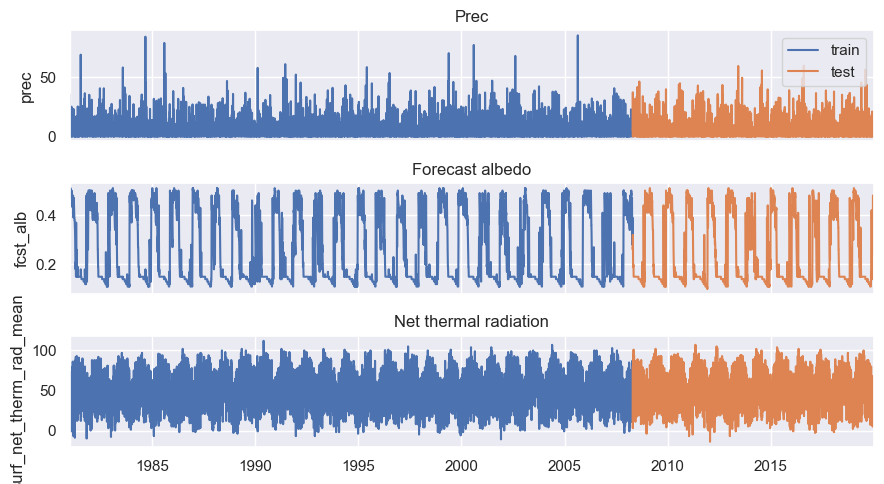

In [15]:
# Plot time series
# ==============================================================================
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(9, 5), sharex=True)

data_train['prec'].plot(label='train', ax=axes[0])
data_test['prec'].plot(label='test', ax=axes[0])
axes[0].set_xlabel('')
axes[0].set_ylabel('prec')
axes[0].set_title('Prec')
axes[0].legend()

data_train['fcst_alb'].plot(label='train', ax=axes[1])
data_test['fcst_alb'].plot(label='test', ax=axes[1])
axes[1].set_xlabel('')
axes[1].set_ylabel('fcst_alb')
axes[1].set_title('Forecast albedo')

data_train['surf_net_therm_rad_mean'].plot(label='train', ax=axes[2])
data_test['surf_net_therm_rad_mean'].plot(label='test', ax=axes[2])
axes[2].set_xlabel('')
axes[2].set_ylabel('surf_net_therm_rad_mean')
axes[2].set_title('Net thermal radiation')

fig.tight_layout()
plt.show()

In [19]:
#from xgboost import XGBRegressor
forecaster = ForecasterAutoregMultiSeries(
                 regressor          = Ridge(random_state=123),
                 lags               = 24,
                 transformer_series = None,
                 transformer_exog   = None,
                 weight_func        = None,
                 series_weights     = None,
                 forecaster_id      = None
             )


forecaster.fit(series=data_train)
forecaster

,DOY,2m_temp_max,2m_temp_mean,2m_temp_min,2m_dp_temp_max,2m_dp_temp_mean,2m_dp_temp_min,10m_wind_u,10m_wind_v,fcst_alb,...,surf_net_therm_rad_max,surf_net_therm_rad_mean,surf_press,total_et,prec,volsw_123,volsw_4,elev,lon,lat
date,,,,,,,,,,,,,,,,,,,,,
1981-01-01,1,0.1,-3.4,-7.9,-1.7,-6.0,-11.8,1.4,0.9,0.49,...,55,18,93487,-0.11,7.28,0.34,0.4,409,4296744,2695478
1981-01-02,2,-0.3,-2.0,-3.5,-2.0,-3.8,-5.0,0.9,1.5,0.50,...,25,13,93422,0.00,15.78,0.34,0.4,409,4296744,2695478
1981-01-03,3,4.1,2.0,-0.1,1.7,-1.0,-2.3,1.4,1.8,0.50,...,33,12,92340,0.06,14.44,0.34,0.4,409,4296744,2695478
1981-01-04,4,3.6,0.5,-2.3,1.7,-0.3,-3.6,1.5,0.2,0.50,...,76,19,91693,0.08,35.63,0.35,0.4,409,4296744,2695478
1981-01-05,5,-2.6,-3.5,-4.4,-4.5,-5.4,-6.6,2.4,-0.5,0.50,...,72,31,92697,0.49,13.67,0.35,0.4,409,4296744,2695478


In [9]:
# Predict and predict_interval
# ==============================================================================
steps = 1

# Predictions
predictions_prec_all = forecaster.predict(steps=steps)
display(predictions_prec_all.head())
print(predictions_prec_all.shape)


,DOY,2m_temp_max,2m_temp_mean,2m_temp_min,2m_dp_temp_max,2m_dp_temp_mean,2m_dp_temp_min,10m_wind_u,10m_wind_v,fcst_alb,...,surf_net_therm_rad_max,surf_net_therm_rad_mean,surf_press,total_et,prec,volsw_123,volsw_4,elev,lon,lat
2008-04-20,107.794984,8.998211,5.908987,0.06588,3.851385,2.230403,-0.715869,0.475681,0.525642,0.305957,...,92.480411,50.750239,91751.986039,1.3757,2.152817,1.182373,0.358772,408.996055,4.296696e+06,2.695448e+06


(1, 25)


In [10]:
# The root mean squared error (RMSE), parameter squared=False gives the RMSE
print("Root mean squared error: %.2f"
      % mean_squared_error(data_test['prec'][:1], predictions_prec_all['prec'], squared=False))

Root mean squared error: 2.12


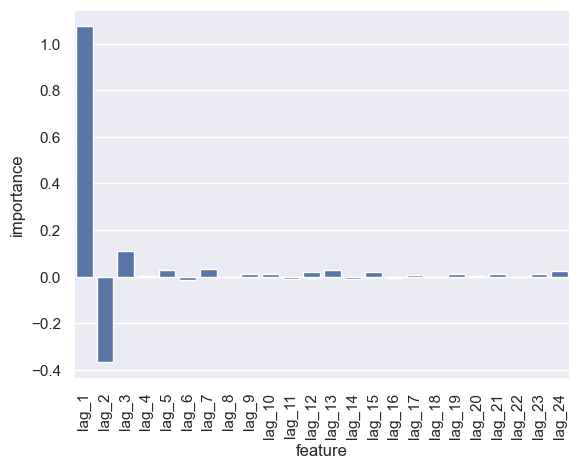

In [11]:
feature_importance = forecaster.get_feature_importances()

# Plot feature importance by using only lags

lags = feature_importance[:24]

# plt.bar(x=lags['feature'], height=lags['importance'])
sns.set_theme()
sns.barplot(x=lags['feature'], y=lags['importance'])
# Set x labels vertically
plt.xticks(rotation=90)
plt.show()

# Export analysing data

In [14]:
# Create empty dataframe
df = pd.DataFrame()

# Create rmse column
df['rmse'] = np.nan

# Add root mean squared error
df.loc[0] = mean_squared_error(data_test['prec'][:1], predictions_prec_all['prec'], squared=False)

df.head()


,rmse
0,2.122817


### Export to csv file

In [13]:
df.to_csv('time_series_model_feature_importance_experimental.csv', sep=';', index=False)